In [1]:
import pandas as pd
import matplotlib.pyplot as plt # Used for plotting graphs
%matplotlib inline 
import plotly.express as px
import klib
import seaborn as sns # for plotting graphs


In [2]:


# GitHub raw URL for the CSV file
url = "https://raw.githubusercontent.com/CBDRH/hds-datathon-data/refs/heads/main/release/epiwatch-latest.csv"

# Read the CSV file from the URL into a pandas DataFrame
data = pd.read_csv(url)


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59369 entries, 0 to 59368
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             59369 non-null  object
 1   publication-date  59369 non-null  object
 2   event-date        13335 non-null  object
 3   country           59369 non-null  object
 4   location          35885 non-null  object
 5   lat_long          53435 non-null  object
 6   diseases          53938 non-null  object
 7   syndromes         7855 non-null   object
 8   url               59369 non-null  object
dtypes: object(9)
memory usage: 4.1+ MB


In [4]:
data.head()

,title,publication-date,event-date,country,location,lat_long,diseases,syndromes,url
0,90123 people sick in one day in the country; D...,2020-09-16,2017-09-16,India,NaN,"23.379, 79.443",covid19,NaN,https://www.manoramaonline.com/news/latest-new...
1,Ludhiana District remains at receiving end;,2020-09-16,2020-09-16,India,"Punjab, Ludhiana, Ludhiana","30.907, 75.849",other,severe acute respiratory syndrome,https://www.tribuneindia.com/news/ludhiana/lud...
2,CIDRAP - India's COVID-19 total tops 5 million...,2020-09-16,2020-09-16,India,NaN,"23.379, 79.443",covid19,NaN,https://flutrackers.com/forum/forum/local-regi...
3,[Myarklamiss.com] LOUISIANA - State reports 42...,2020-09-15,2020-09-15,United States,Louisiana,"30.186, -91.426",covid19,NaN,http://outbreaks.globalincidentmap.com/eventde...
4,[1010 WINS] NEW JERSEY - New Jersey reports 9 ...,2020-09-15,2020-09-15,United States,New Jersey,"39.613, -74.729",covid19,NaN,http://outbreaks.globalincidentmap.com/eventde...


In [5]:
data.describe(include='all')

,title,publication-date,event-date,country,location,lat_long,diseases,syndromes,url
count,59369,59369,13335,59369,35885,53435,53938,7855,59369
unique,51829,1169,1016,12,6632,5645,359,47,52492
top,"The state's top-down daily infections, detecte...",2022-07-29,2023-01,India,"Delhi, New Delhi, New Delhi","28.632, 77.219",covid19,Acute gastroenteritis,https://www.spc.int/phd/epidemics/
freq,69,324,362,16094,931,3661,24594,2147,84


GridSpec(6, 6)

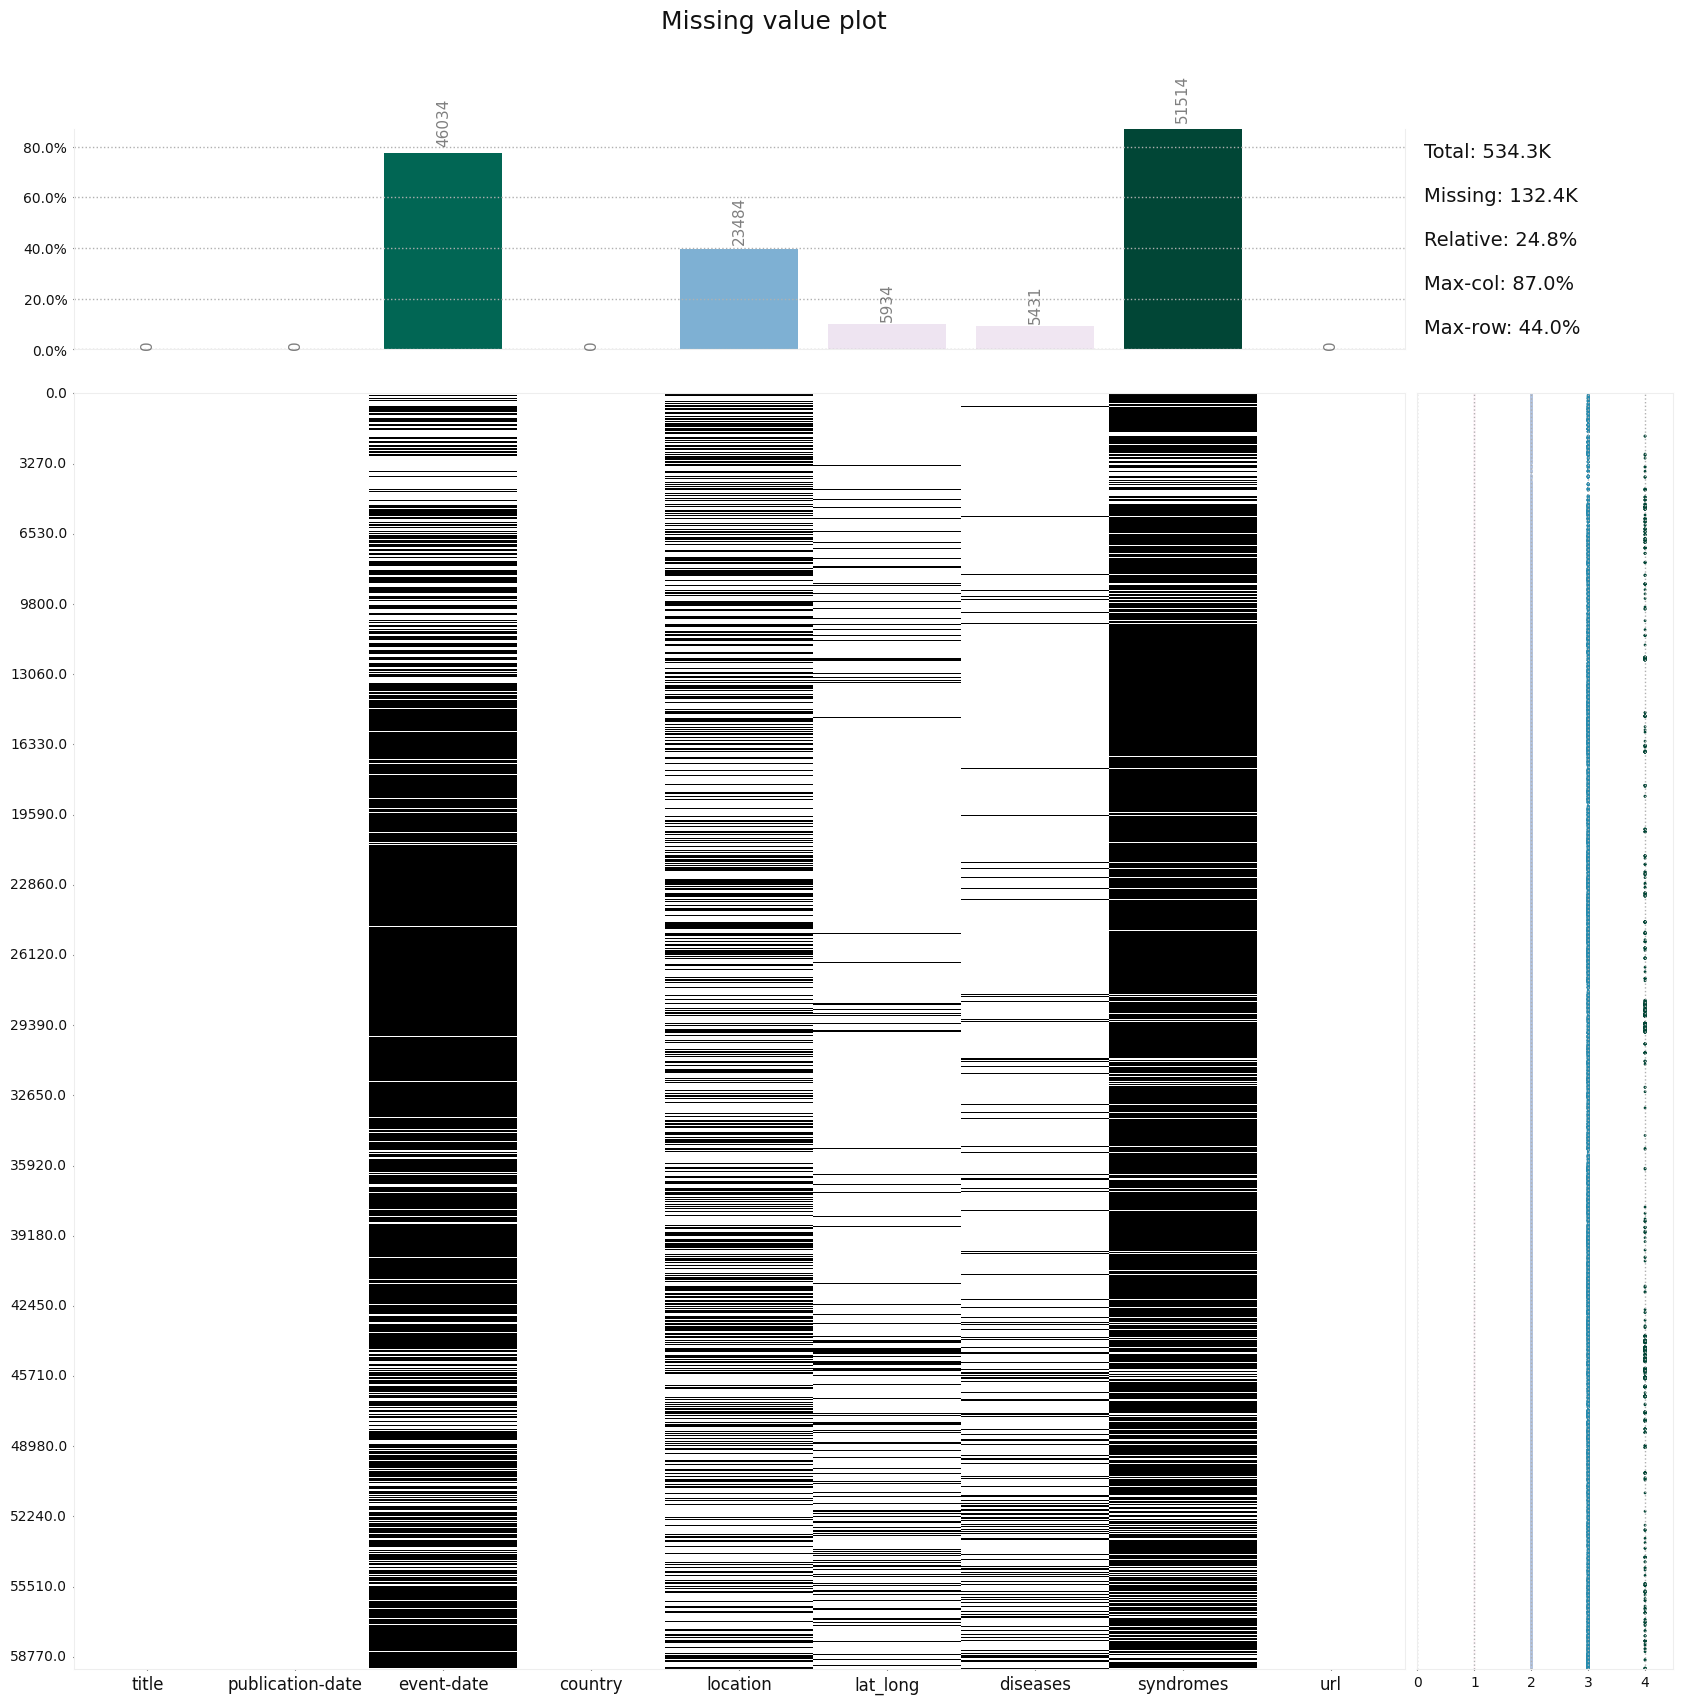

In [6]:
klib.missingval_plot(data)

In [7]:
def clean_string(s):
    # Convert NaN values to 'unknown'
    if pd.isna(s):
        return 'unknown'
    
    if isinstance(s, str):
        if 'other' in s:
            # If "other" is the only word, replace it with "unknown"
            if s.strip() == 'other':
                return 'other'
            # Otherwise, remove "other" and split by either ',' or '/'
            else:
                s = s.replace('other', '').strip(',').strip('/')
                # Split by either comma or slash, clean parts, and join them back
                s = ','.join([part.strip() for part in s.replace('/', ',').split(',') if part.strip()])
                return s
    return s

# Apply the function to the column
data['diseases'] = data['diseases'].apply(clean_string)

data['diseases'] = data['diseases'].str.split(',')
data = data.explode('diseases', ignore_index=False).reset_index(drop=True)

In [8]:
data['diseases'] = data['diseases'].str.strip()

In [9]:
from datetime import datetime

def is_valid_date(date):
    try:
        datetime.strptime(date, '%Y-%m-%d')
        return True
    except (ValueError, TypeError):
        return False

# Fill 'event-date' where it is NaN or not in %Y-%m-%d format
data['event-date'] = data.apply(
    lambda row: row['publication-date'] if not is_valid_date(row['event-date']) else row['event-date'],
    axis=1
)


In [10]:
data['publication-date'] = pd.to_datetime(data['publication-date'], errors='coerce')
data['event-date'] = pd.to_datetime(data['event-date'], errors='coerce')

# List of specific event-dates to replace with publication-date
replace_dates = pd.to_datetime(['2009-03-26', '2014-01-01', '2016-09-09', '2017-09-16', '2019-11-01','2020-06-03','2020-07-17','2030-10-24','2025-10-24'])

# Replace 'event-date' where it's in the replace_dates list
data['event-date'] = data['event-date'].where(~data['event-date'].isin(replace_dates), data['publication-date'])




In [11]:
data['location'] = data['location'].fillna('unknown')
# data['syndromes'] = data['syndromes'].fillna('unknown')


In [12]:

# Fill null values in 'syndrome' with corresponding values from 'diseases'
data['syndromes'] = data['syndromes'].fillna(data['diseases'])

In [13]:
data.isnull().sum()

title                  0
publication-date       0
event-date             0
country                0
location               0
lat_long            6002
diseases               0
syndromes              0
url                    0
dtype: int64

In [14]:
data = data.drop_duplicates()

In [15]:
# Get the frequency of each value in 'diseases' column
value_counts = data['country'].value_counts()

# Sort the counts in ascending order to get the least common values
least_common = value_counts.sort_values(ascending=True)

# Use iter() to iterate through the sorted values
for value, count in iter(least_common.items()):
    print(f'{value}: {count}')


Nigeria: 1001
Argentina: 1093
Australia: 1817
Indonesia: 2224
Brazil: 2723
Ukraine: 3018
United Kingdom: 3096
Vietnam: 3865
Russian Federation: 5207
China: 7594
United States: 12405
India: 16818


In [16]:
# Get the frequency of each value in 'diseases' column
value_counts = data['diseases'].value_counts()

# Sort the counts in ascending order to get the least common values
least_common = value_counts.sort_values(ascending=True)

# Use iter() to iterate through the sorted values
for value, count in iter(least_common.items()):
    print(f'{value}: {count}')


influenza a/h3n5: 1
parvovirus: 1
pseudomonas: 1
hiv: 1
Staphylococcus aureus: 1
influenza/h5n3: 1
aids: 1
anthrax/inhalation: 1
Human metapneumovirus: 1
rat bite fever: 1
h1n1: 1
candidiasis: 1
pneumococcus: 1
MERS: 1
anthrax/unspecified: 1
ehec (e.coli): 1
parechovirus: 1
anaplasmosis: 1
Echovirus: 1
influenza a: 1
Murray Valley Encephalitis: 1
Streptococcus (: 2
unspecified): 2
enterovirus D68: 2
influenza a/h7n3: 2
Powassan Virus infection: 2
Amoebiasis: 2
lyme disease: 2
leishmaniasis: 2
Creutzfeldt-Jakob disease: 2
goatpox: 2
Naegleria fowleri: 2
influenza a/h10n3: 2
Lloviu: 2
Jamestown Canyon virus infection: 2
anthrax/cutaneous: 2
crimean-congo haemorrhagic fever: 3
botulism: 3
psittacosis: 3
ebola haemorrhagic fever: 4
brucellosis: 4
pertussis: 4
hepatitis c: 4
influenza/h5n2: 4
shigellosis: 5
Syphilis: 5
campylobacteriosis: 5
meningococcal meningitis: 5
plague: 5
alaskapox: 6
adenovirus: 7
hepatitis b: 7
influenza/h5n5: 7
hepatitis (unspecified): 8
nipah virus: 8
influenza a/

In [17]:
# Get the frequency of each value in 'diseases' column
value_counts = data['syndromes'].value_counts()

# Sort the counts in ascending order to get the least common values
least_common = value_counts.sort_values(ascending=True)

# Use iter() to iterate through the sorted values
for value, count in iter(least_common.items()):
    print(f'{value}: {count}')


MERS: 1
Acute fever and rash, Febrile syndromes: 1
botulism: 1
Febrile syndromes, Jaundice: 1
lyme disease: 1
Encephalomyelitis: 1
adenovirus: 1
influenza/h5n3: 1
Acute gastroenteritis, Febrile syndromes, Encephalitis: 1
Acute gastroenteritis, Febrile syndromes, Meningitis: 1
Febrile syndromes, conjunctivitis: 1
meningococcal meningitis: 1
candidiasis: 1
Human metapneumovirus: 1
rat bite fever: 1
severe acute respiratory syndrome, pneumonia: 1
rabies: 1
h1n1: 1
pneumococcus: 1
melioidosis: 1
parvovirus: 1
ebola haemorrhagic fever: 1
hiv: 1
aids: 1
anthrax/cutaneous: 1
influenza a: 1
brucellosis: 1
Haemorrhagic Fever, Acute gastroenteritis: 1
severe acute respiratory syndrome, Influenza-like illness, Acute fever and rash: 1
Haemorrhagic Fever, severe acute respiratory syndrome, Acute fever and rash: 1
listeriosis: 1
Influenza-like illness, Encephalitis: 1
severe acute respiratory syndrome, Influenza-like illness, pneumonia: 1
Acute gastroenteritis, Meningitis: 1
anthrax/inhalation: 1
Fa

In [18]:
# Get the frequency of each value in 'diseases' column
value_counts = data['diseases'].value_counts()

# Sort the counts in ascending order to get the least common values
least_common = value_counts.sort_values(ascending=True)

# Drop rows where the disease count is less than 200
diseases_to_keep = least_common[least_common >= 200].index
data = data[data['diseases'].isin(diseases_to_keep)].reset_index(drop=True)

In [19]:
data.isnull().sum()

title                  0
publication-date       0
event-date             0
country                0
location               0
lat_long            5873
diseases               0
syndromes              0
url                    0
dtype: int64

In [20]:
target_diseases = {"covid19", "dengue", "Mpox", "legionnaires'", "measles", "cholera", "influenza a/h1n1","influenza a/h1n1"}

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59122 entries, 0 to 59121
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   title             59122 non-null  object        
 1   publication-date  59122 non-null  datetime64[ns]
 2   event-date        59122 non-null  datetime64[ns]
 3   country           59122 non-null  object        
 4   location          59122 non-null  object        
 5   lat_long          53249 non-null  object        
 6   diseases          59122 non-null  object        
 7   syndromes         59122 non-null  object        
 8   url               59122 non-null  object        
dtypes: datetime64[ns](2), object(7)
memory usage: 4.1+ MB


In [22]:
data.head()

,title,publication-date,event-date,country,location,lat_long,diseases,syndromes,url
0,90123 people sick in one day in the country; D...,2020-09-16,2020-09-16,India,unknown,"23.379, 79.443",covid19,covid19,https://www.manoramaonline.com/news/latest-new...
1,CIDRAP - India's COVID-19 total tops 5 million...,2020-09-16,2020-09-16,India,unknown,"23.379, 79.443",covid19,covid19,https://flutrackers.com/forum/forum/local-regi...
2,[Myarklamiss.com] LOUISIANA - State reports 42...,2020-09-15,2020-09-15,United States,Louisiana,"30.186, -91.426",covid19,covid19,http://outbreaks.globalincidentmap.com/eventde...
3,[1010 WINS] NEW JERSEY - New Jersey reports 9 ...,2020-09-15,2020-09-15,United States,New Jersey,"39.613, -74.729",covid19,covid19,http://outbreaks.globalincidentmap.com/eventde...
4,[WLS] ILLINOIS - Pritzker warns of budget cuts...,2020-09-15,2020-09-15,United States,Illinois,"40.114, -89.159",covid19,covid19,http://outbreaks.globalincidentmap.com/eventde...


In [23]:
data['event-date'] = pd.to_datetime(data['event-date'])

# Count the frequency of rows for each date
date_counts = data['event-date'].value_counts().reset_index()
date_counts.columns = ['date', 'count']
date_counts = date_counts.sort_values(by='date')  # Sort by date

# Create a bar graph using Plotly
fig = px.bar(date_counts, x='date', y='count', title='Frequency of Rows by Date',
             labels={'date': 'Date', 'count': 'Frequency'})

# Display the graph
fig.show()

In [24]:
data.to_csv('test2.csv', index=False)

In [25]:
data.drop(columns=['title','url','lat_long'], inplace=True)

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59122 entries, 0 to 59121
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   publication-date  59122 non-null  datetime64[ns]
 1   event-date        59122 non-null  datetime64[ns]
 2   country           59122 non-null  object        
 3   location          59122 non-null  object        
 4   diseases          59122 non-null  object        
 5   syndromes         59122 non-null  object        
dtypes: datetime64[ns](2), object(4)
memory usage: 2.7+ MB


In [27]:
data['event-date'] = pd.to_datetime(data['event-date'])

# filter_data = data.loc[data['country'] == 'India'] # Filter data for country
# filter_data = data.loc[(data['country'] == 'India') & (data['diseases'] == 'malaria')]

def plot_country_disease(country,disease):
    filter_data = data.loc[(data['country'] == country) & (data['diseases'] == disease)]
    date_counts = filter_data['event-date'].value_counts().reset_index()
    date_counts.columns = ['date', 'count']
    date_counts = date_counts.sort_values(by='date')  # Sort by date

    # Create a bar graph using Plotly
    fig = px.bar(date_counts, x='date', y='count', title=f'Frequency of {disease} in {country}',
                 labels={'date': 'Date', 'count': 'Frequency'})

    # Display the graph
    fig.show()


In [28]:
plot_country_disease('India','malaria')

In [29]:
plot_country_disease('India','dengue')

In [30]:
plot_country_disease('Russian Federation','cholera')

In [31]:
plot_country_disease('Nigeria','Mpox')

In [32]:
klib.missingval_plot(data)

No missing values found in the dataset.


In [33]:
# Specify the disease and country to filter
disease_name = "dengue"  # Replace with your desired disease
country_name = "India"  # Replace with your desired country

# Filter the dataset
filtered_data = data[(data['diseases'] == disease_name) & (data['country'] == country_name)]


In [34]:
data.tail(15)

,publication-date,event-date,country,location,diseases,syndromes
59107,2023-11-28,2023-11-28,China,unknown,unknown,pneumonia
59108,2023-11-28,2023-11-28,Ukraine,"Dnipropetrovsk Oblast, Dniprovskyi raion, Dnipro",measles,measles
59109,2023-11-28,2023-11-28,China,unknown,unknown,Influenza-like illness
59110,2023-11-28,2023-11-28,Argentina,unknown,avian influenza/unspecified,avian influenza/unspecified
59111,2023-11-28,2023-11-28,China,unknown,unknown,pneumonia
59112,2023-11-28,2023-11-28,China,unknown,unknown,Influenza-like illness
59113,2023-11-28,2023-11-28,Ukraine,Zhytomyr region,unknown,severe acute respiratory syndrome
59114,2023-11-28,2023-11-28,Ukraine,Zhytomyr region,influenza,influenza
59115,2023-11-28,2023-11-28,Ukraine,Zhytomyr region,covid19,covid19
59116,2023-11-28,2023-11-28,Ukraine,Rivne,unknown,severe acute respiratory syndrome


C:\Users\VJ\AppData\Local\Temp\ipykernel_1828\182885382.py:21: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

C:\Users\VJ\AppData\Local\Temp\ipykernel_1828\182885382.py:22: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

13:43:42 - cmdstanpy - INFO - Chain [1] start processing


Filtered Data Info:
<class 'pandas.core.frame.DataFrame'>
Index: 4994 entries, 16 to 59091
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   publication-date  4994 non-null   datetime64[ns]
 1   event-date        4994 non-null   datetime64[ns]
 2   country           4994 non-null   object        
 3   location          4994 non-null   object        
 4   diseases          4994 non-null   object        
 5   syndromes         4994 non-null   object        
dtypes: datetime64[ns](2), object(4)
memory usage: 273.1+ KB
None
   publication-date event-date             country  \
16       2020-09-16 2020-09-16  Russian Federation   
27       2020-09-16 2020-09-16  Russian Federation   
28       2020-09-16 2020-09-16  Russian Federation   
33       2020-09-16 2020-09-16  Russian Federation   
35       2020-09-16 2020-09-16  Russian Federation   

                       location diseases syndromes  
1

13:43:42 - cmdstanpy - INFO - Chain [1] done processing


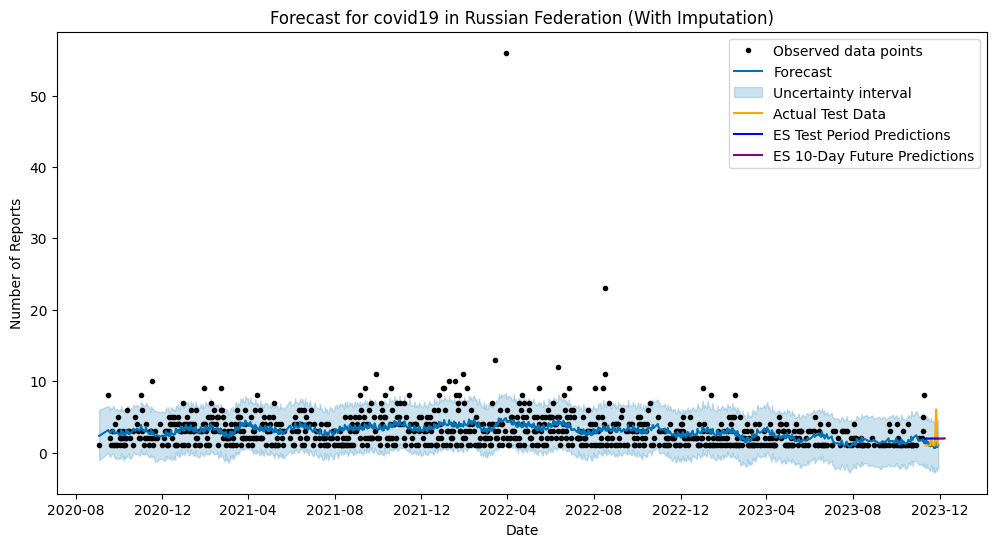

13:43:43 - cmdstanpy - INFO - Chain [1] start processing
13:43:43 - cmdstanpy - INFO - Chain [1] done processing


Prophet Test Period Predictions:
[1.3809018  1.25896219 1.92742444 1.3972385  1.25182607 1.47579952
 0.92730108 0.98857087 0.87777142 1.56138366]
Prophet 10-Day Forward Predictions:
[1.04977447 0.92574096 1.17325002 0.64979802 0.73699864 0.65242577
 1.36202595 0.87570002 0.77585852 1.04616934]
Exponential Smoothing Test Period Predictions:
872    1.938785
873    1.978811
874    1.938785
875    1.978811
876    1.938785
877    1.978811
878    1.938785
879    1.978811
880    1.938785
881    1.978811
dtype: float64
Exponential Smoothing 10-Day Forward Predictions:
882    1.938785
883    1.978811
884    1.938785
885    1.978811
886    1.938785
887    1.978811
888    1.938785
889    1.978811
890    1.938785
891    1.978811
dtype: float64
Prophet Errors: MAE = 1.0956240653672729, RMSE = 1.8060930478214863
Exponential Smoothing Errors: MAE = 1.1875216273095495, RMSE = 1.549718532908004

Processing disease: unknown
Time Series Length: 306
Time Series Preview:
event-date
2020-09-17    2
2020-09-

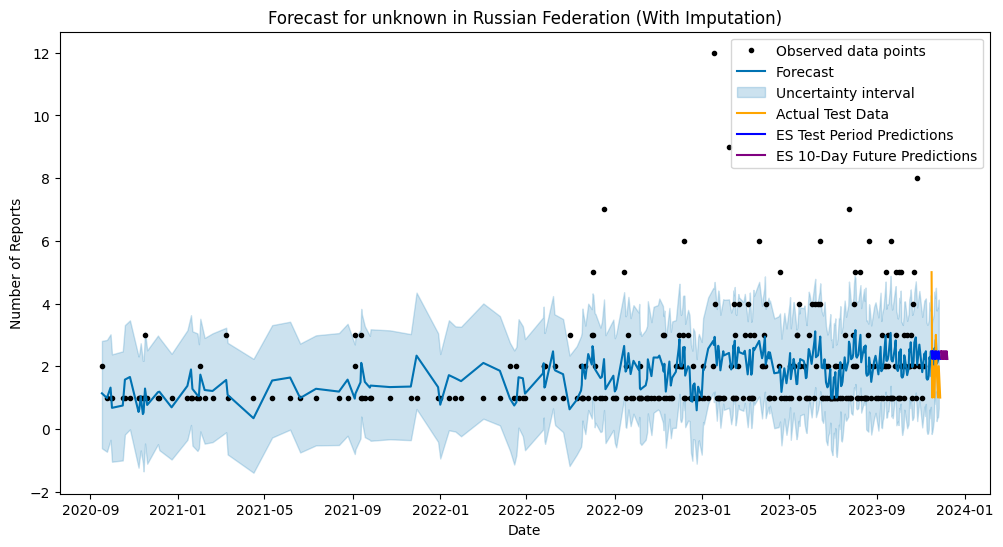

13:43:43 - cmdstanpy - INFO - Chain [1] start processing
13:43:43 - cmdstanpy - INFO - Chain [1] done processing


Prophet Test Period Predictions:
[2.23757754 2.47766198 1.61820168 1.57048009 1.58607362 1.69442895
 2.28425658 2.17532844 2.47345305 1.67452186]
Prophet 10-Day Forward Predictions:
[1.68814623 1.76416725 1.93027982 2.57347423 2.51188143 2.84979456
 2.08175881 2.1162479  2.20220834 2.36671184]
Exponential Smoothing Test Period Predictions:
296    2.477618
297    2.230918
298    2.477618
299    2.230918
300    2.477618
301    2.230918
302    2.477618
303    2.230918
304    2.477618
305    2.230918
dtype: float64
Exponential Smoothing 10-Day Forward Predictions:
306    2.477618
307    2.230918
308    2.477618
309    2.230918
310    2.477618
311    2.230918
312    2.477618
313    2.230918
314    2.477618
315    2.230918
dtype: float64
Prophet Errors: MAE = 0.9519420196551371, RMSE = 1.1959459575271563
Exponential Smoothing Errors: MAE = 1.0125608437627258, RMSE = 1.180127698947638

Processing disease: influenza
Time Series Length: 210
Time Series Preview:
event-date
2020-09-17    1
2020-1

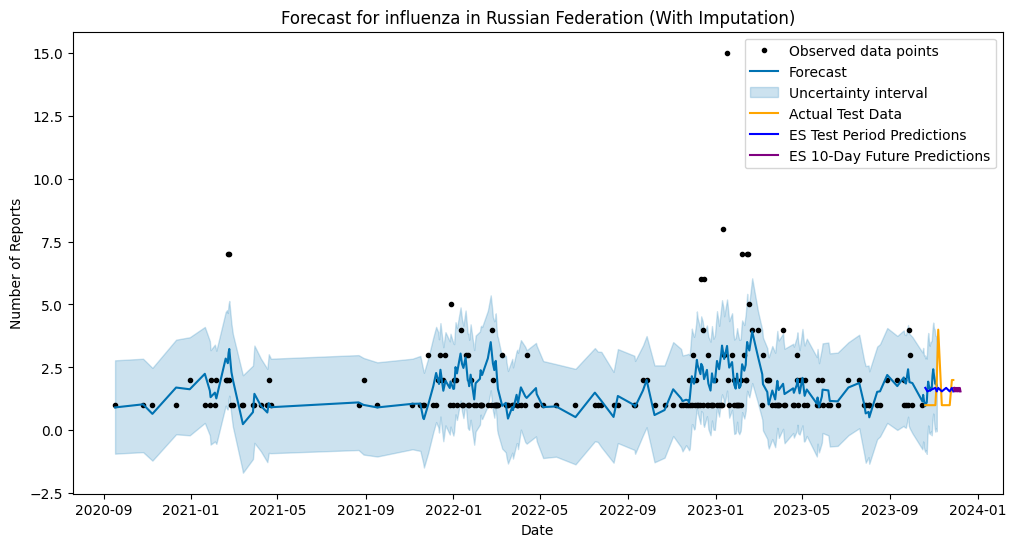

13:43:44 - cmdstanpy - INFO - Chain [1] start processing
13:43:44 - cmdstanpy - INFO - Chain [1] done processing


Prophet Test Period Predictions:
[1.40848542 1.20527351 1.07317103 0.9619571  1.08958572 1.09647007
 1.62039083 1.93529176 1.7741948  1.66893811]
Prophet 10-Day Forward Predictions:
[1.56859867 1.69089164 1.67646373 2.16379642 2.42798275 2.2036103
 2.0244548  1.841847   1.87600703 1.77026492]
Exponential Smoothing Test Period Predictions:
200    1.687359
201    1.547385
202    1.687359
203    1.547385
204    1.687359
205    1.547385
206    1.687359
207    1.547385
208    1.687359
209    1.547385
dtype: float64
Exponential Smoothing 10-Day Forward Predictions:
210    1.687359
211    1.547385
212    1.687359
213    1.547385
214    1.687359
215    1.547385
216    1.687359
217    1.547385
218    1.687359
219    1.547385
dtype: float64
Prophet Errors: MAE = 0.6844406874764719, RMSE = 1.0579200239497801
Exponential Smoothing Errors: MAE = 0.723474357275493, RMSE = 0.9039939748726489

Processing disease: measles
Time Series Length: 166
Time Series Preview:
event-date
2020-09-23    1
2020-10-2

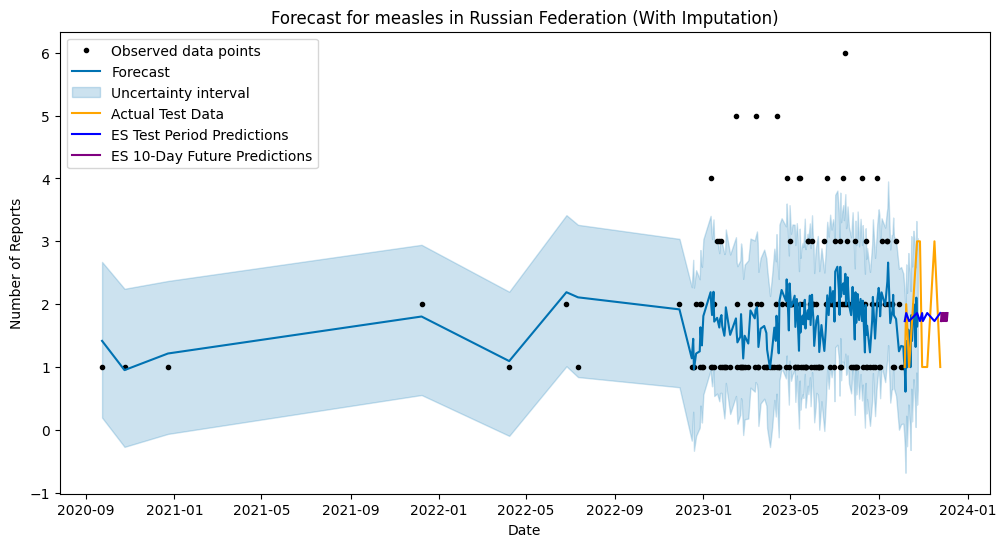

13:43:44 - cmdstanpy - INFO - Chain [1] start processing
13:43:44 - cmdstanpy - INFO - Chain [1] done processing


Prophet Test Period Predictions:
[1.10350246 0.97550004 0.60765669 1.41569595 0.99364423 1.19681315
 1.59507053 1.42311387 1.33537464 0.99808049]
Prophet 10-Day Forward Predictions:
[1.82644456 1.41423651 1.61677053 2.00417547 1.81166063 1.69440608
 1.31960471 2.10362577 1.64155532 1.79014953]
Exponential Smoothing Test Period Predictions:
156    1.730769
157    1.858974
158    1.730769
159    1.858974
160    1.730769
161    1.858974
162    1.730769
163    1.858974
164    1.730769
165    1.858974
dtype: float64
Exponential Smoothing 10-Day Forward Predictions:
166    1.730769
167    1.858974
168    1.730769
169    1.858974
170    1.730769
171    1.858974
172    1.730769
173    1.858974
174    1.730769
175    1.858974
dtype: float64
Prophet Errors: MAE = 0.7992547984890707, RMSE = 1.0532131781410996
Exponential Smoothing Errors: MAE = 0.8589743577123873, RMSE = 0.914292244280064

Processing disease: avian influenza/unspecified
Time Series Length: 237
Time Series Preview:
event-date
2020

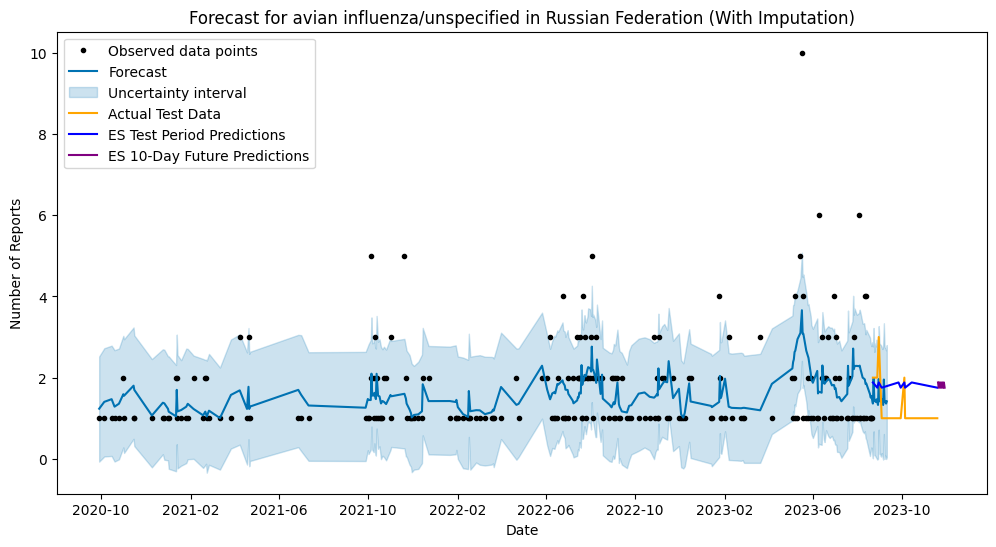

13:43:45 - cmdstanpy - INFO - Chain [1] start processing


Prophet Test Period Predictions:
[1.3613387  1.9807754  1.41949093 1.45255149 1.39936873 1.46581477
 1.39317521 1.32767428 1.96450325 1.41612522]
Prophet 10-Day Forward Predictions:
[1.45756703 1.40836493 1.47467039 1.39818915 1.32568806 1.9530016
 1.39331188 1.42241373 1.36063235 1.41490086]
Exponential Smoothing Test Period Predictions:
227    1.880984
228    1.752170
229    1.880984
230    1.752170
231    1.880984
232    1.752170
233    1.880984
234    1.752170
235    1.880984
236    1.752170
dtype: float64
Exponential Smoothing 10-Day Forward Predictions:
237    1.880984
238    1.752170
239    1.880984
240    1.752170
241    1.880984
242    1.752170
243    1.880984
244    1.752170
245    1.880984
246    1.752170
dtype: float64
Prophet Errors: MAE = 0.5871257509613546, RMSE = 0.7117992623444805
Exponential Smoothing Errors: MAE = 0.6375526932960457, RMSE = 0.7181402026668654

Processing disease: influenza a/h5n1
Time Series Length: 60
Time Series Preview:
event-date
2020-08-12    1


13:43:45 - cmdstanpy - INFO - Chain [1] done processing


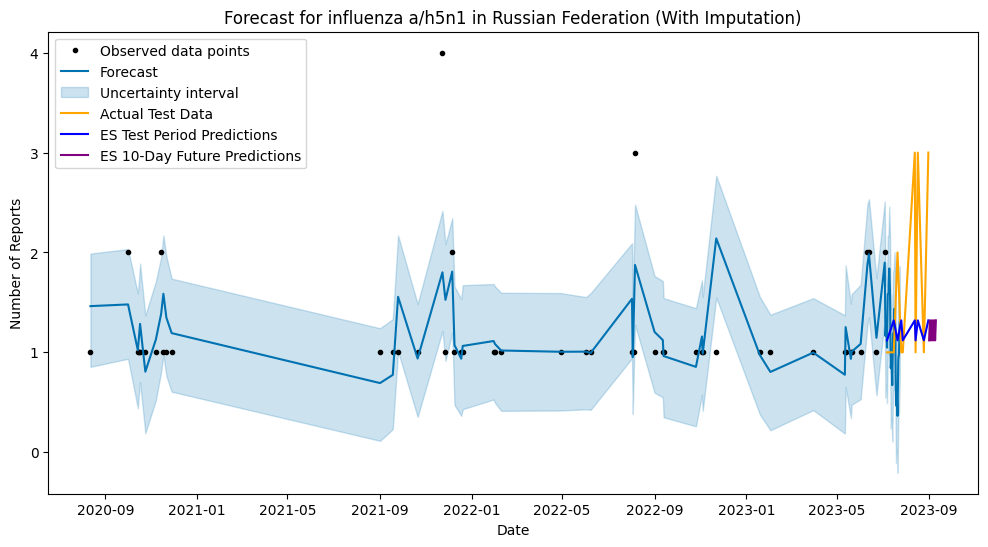

13:43:45 - cmdstanpy - INFO - Chain [1] start processing


Prophet Test Period Predictions:
[1.16358534 1.30351492 1.04723984 1.58188227 1.58973214 1.83960023
 1.61126263 0.84174297 0.95174645 0.67132145]
Prophet 10-Day Forward Predictions:
[1.1887543  1.18735617 1.43678489 1.21746289 0.46683826 0.60580355
 0.36434822 0.93045076 0.98686929 1.30247329]
Exponential Smoothing Test Period Predictions:
50    1.119903
51    1.320032
52    1.119903
53    1.320032
54    1.119903
55    1.320032
56    1.119903
57    1.320032
58    1.119903
59    1.320032
dtype: float64
Exponential Smoothing 10-Day Forward Predictions:
60    1.119903
61    1.320032
62    1.119903
63    1.320032
64    1.119903
65    1.320032
66    1.119903
67    1.320032
68    1.119903
69    1.320032
dtype: float64
Prophet Errors: MAE = 0.8898326363173862, RMSE = 1.1625970752763164
Exponential Smoothing Errors: MAE = 0.7039676641141411, RMSE = 0.974874240587789

Processing disease: dengue
Time Series Length: 59
Time Series Preview:
event-date
2021-01-07    2
2021-01-12    1
2021-02-27    

13:43:45 - cmdstanpy - INFO - Chain [1] done processing


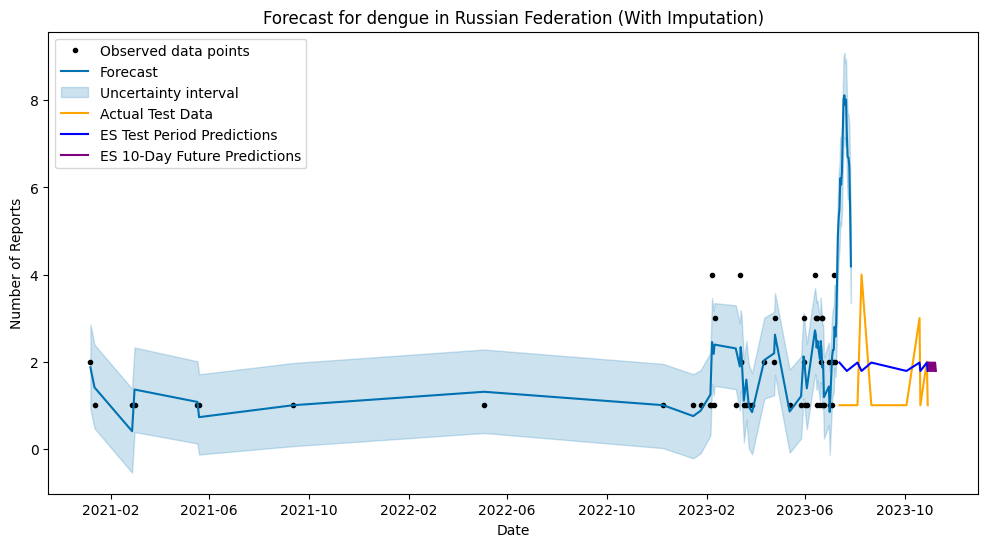

13:43:46 - cmdstanpy - INFO - Chain [1] start processing


Prophet Test Period Predictions:
[2.57565647 2.88867396 3.87167504 4.87933077 5.29468579 5.52271401
 6.21006917 6.06534985 6.3682699  7.24155519]
Prophet 10-Day Forward Predictions:
[8.03180717 8.11616852 7.89619791 8.01789104 7.19215691 6.70413168
 6.68514313 6.49356067 5.52136222 4.18782355]
Exponential Smoothing Test Period Predictions:
49    1.979289
50    1.786776
51    1.979289
52    1.786776
53    1.979289
54    1.786776
55    1.979289
56    1.786776
57    1.979289
58    1.786776
dtype: float64
Exponential Smoothing 10-Day Forward Predictions:
59    1.979289
60    1.786776
61    1.979289
62    1.786776
63    1.979289
64    1.786776
65    1.979289
66    1.786776
67    1.979289
68    1.786776
dtype: float64
Prophet Errors: MAE = 3.4917980163912445, RMSE = 3.8466855495267143
Exponential Smoothing Errors: MAE = 0.9339617997549456, RMSE = 1.0627195687188475

Processing disease: influenza b
Time Series Length: 62
Time Series Preview:
event-date
2021-02-20    6
2021-02-21    8
2021-02-

13:43:46 - cmdstanpy - INFO - Chain [1] done processing


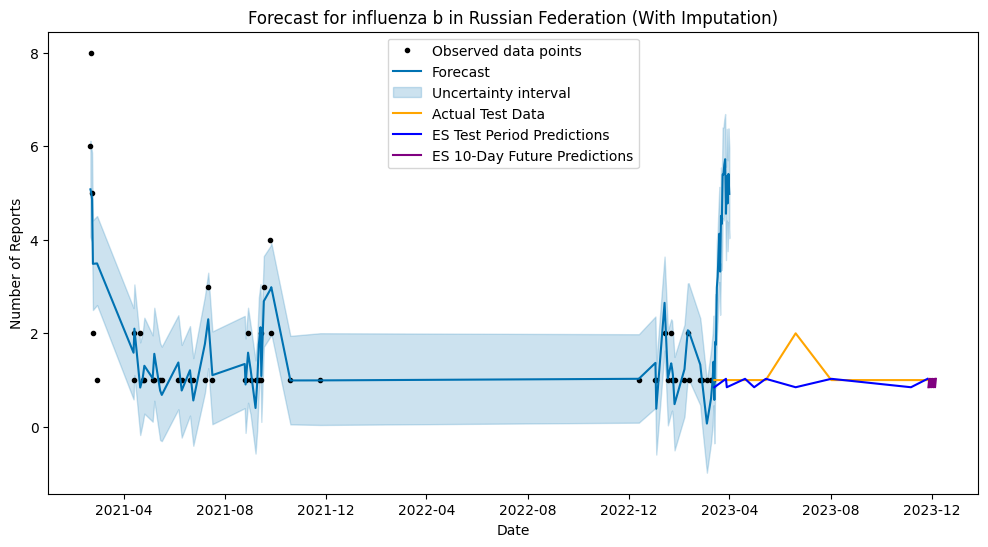

13:43:46 - cmdstanpy - INFO - Chain [1] start processing


Prophet Test Period Predictions:
[1.39231207 0.57584439 1.8180396  1.75872427 2.98268835 3.20670678
 3.69445211 4.12915738 3.3204487  4.51074405]
Prophet 10-Day Forward Predictions:
[4.340037   5.39473979 5.39466577 5.60786517 5.7231761  4.55691313
 5.35909384 4.7780271  5.40894276 4.98074847]
Exponential Smoothing Test Period Predictions:
52    0.847052
53    1.027227
54    0.847052
55    1.027227
56    0.847052
57    1.027227
58    0.847052
59    1.027227
60    0.847052
61    1.027227
dtype: float64
Exponential Smoothing 10-Day Forward Predictions:
62    0.847052
63    1.027227
64    0.847052
65    1.027227
66    0.847052
67    1.027227
68    0.847052
69    1.027227
70    0.847052
71    1.027227
dtype: float64
Prophet Errors: MAE = 1.7237428923073714, RMSE = 2.0187093843382673
Exponential Smoothing Errors: MAE = 0.19008711401374084, RMSE = 0.3776991347788663

Processing disease: legionnaires'
Time Series Length: 3
Time Series Preview:
event-date
2021-09-14    1
2022-10-14    1
2022-1

13:43:47 - cmdstanpy - INFO - Chain [1] done processing


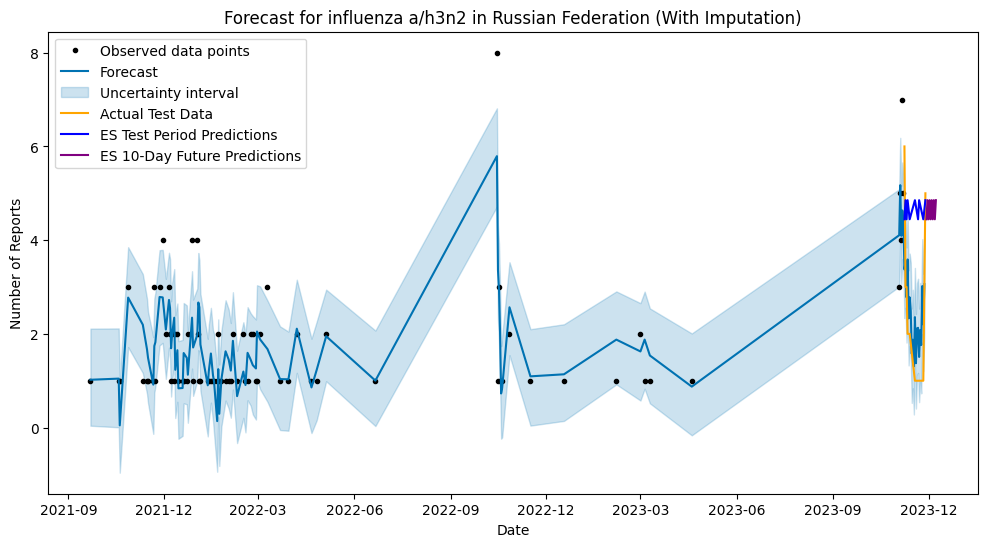

13:43:47 - cmdstanpy - INFO - Chain [1] start processing
13:43:47 - cmdstanpy - INFO - Chain [1] done processing


Prophet Test Period Predictions:
[3.37472095 3.53885411 2.77819795 3.58759162 2.33057672 2.77912927
 2.49221244 1.57577562 1.87477377 1.30754805]
Prophet 10-Day Forward Predictions:
[2.35702032 1.37370234 2.11601593 2.1294126  1.50690003 2.08153304
 1.7611973  3.0201279  2.20215696 3.06118285]
Exponential Smoothing Test Period Predictions:
80    4.445039
81    4.853070
82    4.445039
83    4.853070
84    4.445039
85    4.853070
86    4.445039
87    4.853070
88    4.445039
89    4.853070
dtype: float64
Exponential Smoothing 10-Day Forward Predictions:
90    4.445039
91    4.853070
92    4.445039
93    4.853070
94    4.445039
95    4.853070
96    4.445039
97    4.853070
98    4.445039
99    4.853070
dtype: float64
Prophet Errors: MAE = 1.3718446582325219, RMSE = 1.7315982533308938
Exponential Smoothing Errors: MAE = 2.489432877747151, RMSE = 2.7478831585705485

Processing disease: influenza a/h5n6
Time Series Length: 1
Time Series Preview:
event-date
2021-10-27    1
Name: num_reports, dt

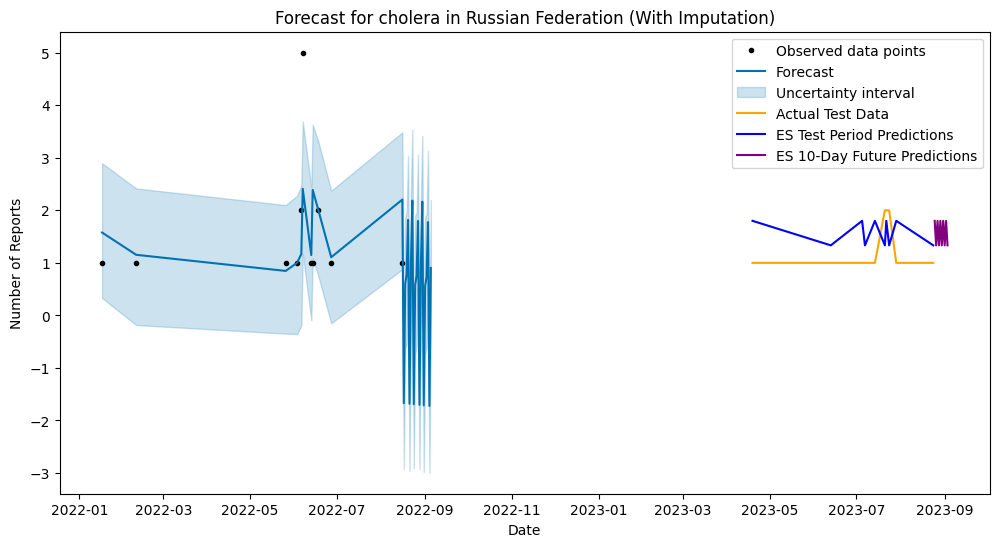

13:43:47 - cmdstanpy - INFO - Chain [1] start processing


Prophet Test Period Predictions:
[-1.67123803  0.60125498  0.77485169  1.81669495 -1.68291684  0.94357055
  2.1847254  -1.69167985  0.58081315  0.75440987]
Prophet 10-Day Forward Predictions:
[ 1.79625312 -1.70335866  0.92312873  2.16428357 -1.71212168  0.56037133
  0.73396804  1.7758113  -1.72380048  0.9026869 ]
Exponential Smoothing Test Period Predictions:
11    1.799913
12    1.333190
13    1.799913
14    1.333190
15    1.799913
16    1.333190
17    1.799913
18    1.333190
19    1.799913
20    1.333190
dtype: float64
Exponential Smoothing 10-Day Forward Predictions:
21    1.799913
22    1.333190
23    1.799913
24    1.333190
25    1.799913
26    1.333190
27    1.799913
28    1.333190
29    1.799913
30    1.333190
dtype: float64
Prophet Errors: MAE = 1.2392354817502023, RMSE = 1.7385319747289603
Exponential Smoothing Errors: MAE = 0.5732928861691202, RMSE = 0.6182066731222342

Processing disease: influenza a/h1n1
Time Series Length: 62
Time Series Preview:
event-date
2022-01-22    1

13:43:48 - cmdstanpy - INFO - Chain [1] done processing


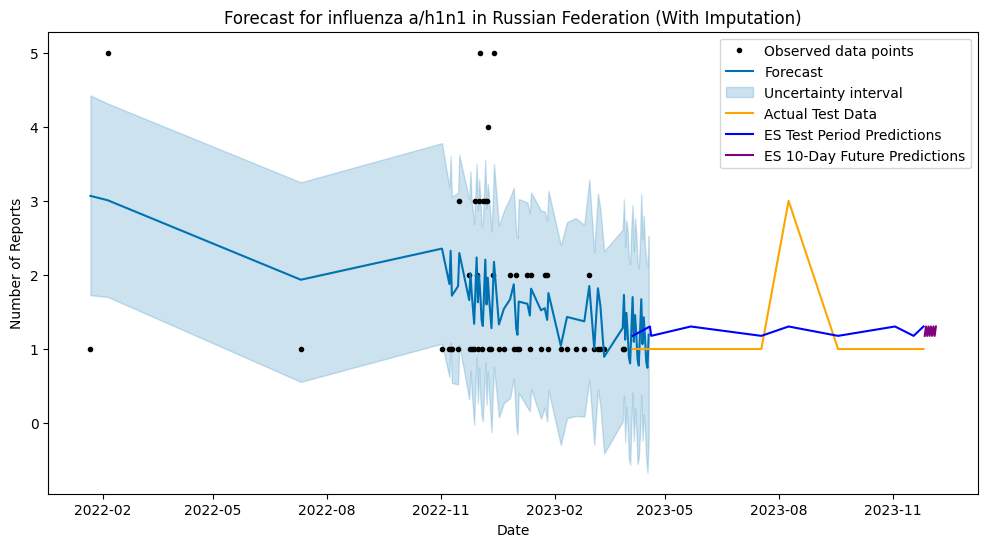

13:43:48 - cmdstanpy - INFO - Chain [1] start processing
13:43:48 - cmdstanpy - INFO - Chain [1] done processing


Prophet Test Period Predictions:
[1.12559346 1.48771122 1.22516025 0.88580958 0.80592241 1.25386893
 1.70160884 1.09587795 1.4579957  1.19544473]
Prophet 10-Day Forward Predictions:
[0.85609406 0.77620689 1.22415342 1.67189333 1.06616243 1.42828019
 1.16572922 0.82637854 0.74649138 1.1944379 ]
Exponential Smoothing Test Period Predictions:
52    1.177604
53    1.304061
54    1.177604
55    1.304061
56    1.177604
57    1.304061
58    1.177604
59    1.304061
60    1.177604
61    1.304061
dtype: float64
Exponential Smoothing 10-Day Forward Predictions:
62    1.177604
63    1.304061
64    1.177604
65    1.304061
66    1.177604
67    1.304061
68    1.177604
69    1.304061
70    1.177604
71    1.304061
dtype: float64
Prophet Errors: MAE = 0.43437912393292244, RMSE = 0.6444702178840861
Exponential Smoothing Errors: MAE = 0.38002063094669014, RMSE = 0.583415594292604

Processing disease: chikungunya
Time Series Length: 1
Time Series Preview:
event-date
2022-05-04    1
Name: num_reports, dtype

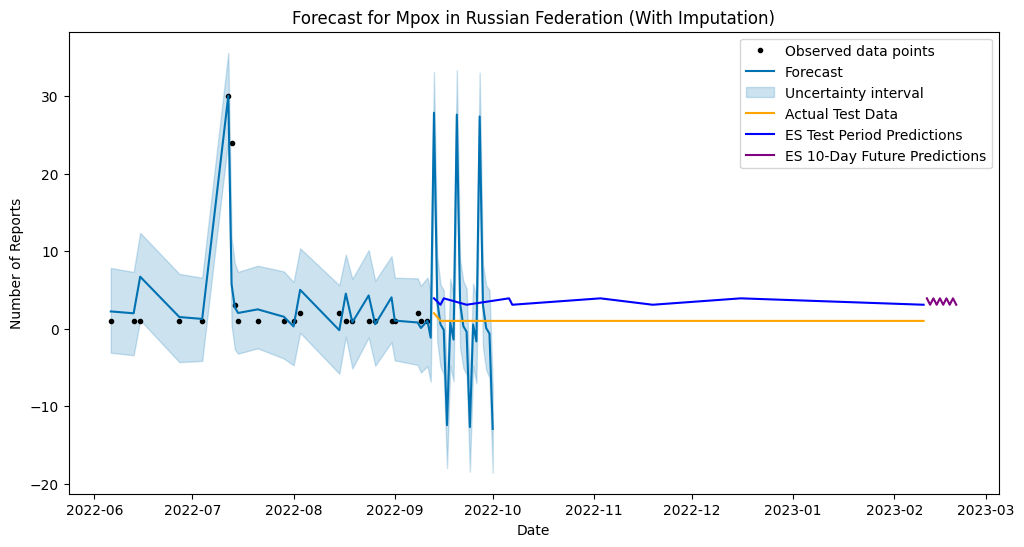

Prophet Test Period Predictions:
[ -1.164873    27.84577667   3.55470851   0.55355385  -0.15632523
 -12.44530666   0.7747088   -1.40682545  27.60382422   3.31275606]
Prophet 10-Day Forward Predictions:
[  0.3116014   -0.39827768 -12.68725911   0.53275635  -1.6487779
  27.36187177   3.07080361   0.06964895  -0.64023013 -12.92921156]
Exponential Smoothing Test Period Predictions:
23    3.909091
24    3.083333
25    3.909091
26    3.083333
27    3.909091
28    3.083333
29    3.909091
30    3.083333
31    3.909091
32    3.083333
dtype: float64
Exponential Smoothing 10-Day Forward Predictions:
33    3.909091
34    3.083333
35    3.909091
36    3.083333
37    3.909091
38    3.083333
39    3.909091
40    3.083333
41    3.909091
42    3.083333
dtype: float64
Prophet Errors: MAE = 7.916213314418019, RMSE = 12.800418834138613
Exponential Smoothing Errors: MAE = 2.396212001730095, RMSE = 2.433048526263086


In [54]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

# Specify the country to filter
country_name = "Russian Federation"  # Replace with your desired country

# Filter the dataset for the specified country
filtered_data = data[data['country'] == country_name].copy()

# Impute missing values in filtered_data
filtered_data['publication-date'] = pd.to_datetime(filtered_data['publication-date'], errors='coerce')
filtered_data = filtered_data.sort_values(by='publication-date')  # Sort by date for consistency
filtered_data.fillna(method='ffill', inplace=True)
filtered_data.fillna(method='bfill', inplace=True)

# Debug: Print dataset info after imputation
print("Filtered Data Info:")
print(filtered_data.info())
print(filtered_data.head())

# Get unique diseases
unique_diseases = filtered_data['diseases'].unique()

# Loop through each disease and perform forecasting
for disease_name in unique_diseases:
    print(f"\nProcessing disease: {disease_name}")

    # Filter data for the current disease
    disease_data = filtered_data[filtered_data['diseases'] == disease_name]

    # Create a time series: Count the number of reports per day
    time_series = disease_data.groupby(disease_data['event-date'].dt.date).size()
    time_series.index = pd.to_datetime(time_series.index)
    time_series = time_series.rename("num_reports")

    # Debug: Print time series info
    print("Time Series Length:", len(time_series))
    print("Time Series Preview:")
    print(time_series.head())

    # Check if time series is non-empty and has numeric data
    if time_series.empty or not np.issubdtype(time_series.dtype, np.number):
        print("Time series is empty or contains non-numeric data. Skipping.")
        continue

    # Ensure we have enough data for training and testing
    if len(time_series) <= 10:
        print("Not enough data for training and testing. At least 10 days of data are required.")
        continue

    # Prepare data for Prophet
    df_prophet = time_series.reset_index()
    df_prophet.columns = ['ds', 'y']

    # Split data into training and testing sets
    train_data = df_prophet[:-10]  # Use all except the last 10 days for training
    test_data = df_prophet[-10:]  # Use the last 10 days for testing

    # Debug: Print training and testing data
    print("Training Data Length:", len(train_data))
    print("Testing Data Length:", len(test_data))

    # Fit Prophet Model
    prophet_model = Prophet()
    prophet_model.fit(train_data)

    # Forecast future values with Prophet
    future = prophet_model.make_future_dataframe(periods=20)  # 10 days for testing + 10 days forward
    forecast = prophet_model.predict(future)

    # Fit Exponential Smoothing Model
    es_model = ExponentialSmoothing(train_data['y'], seasonal='add', seasonal_periods=2).fit()
    es_forecast = es_model.forecast(steps=20)

    # Plot the results
  # Plot the results
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot Prophet's full forecast (including both the training and future data)
    prophet_model.plot(forecast, ax=ax)

    # Plot the actual test data
    ax.plot(test_data['ds'], test_data['y'], label="Actual Test Data", color="orange")

    # Plot Exponential Smoothing predictions for the test period
    ax.plot(test_data['ds'], es_forecast[:10], label="ES Test Period Predictions", color="blue")

    # Plot Exponential Smoothing predictions for the 10-day future period
    future_dates = pd.date_range(test_data['ds'].iloc[-1] + pd.Timedelta(days=1), periods=10)
    ax.plot(future_dates, es_forecast[10:], label="ES 10-Day Future Predictions", color="purple")

    plt.title(f"Forecast for {disease_name} in {country_name} (With Imputation)")
    plt.xlabel("Date")
    plt.ylabel("Number of Reports")
    plt.legend()
    plt.grid()
    plt.show()


    # Print forecast values
    forecast_values_prophet_test = forecast['yhat'][-20:-10].values  # Test period predictions
    forecast_values_prophet_forward = forecast['yhat'][-10:].values  # 10 days forward
    forecast_values_es_test = es_forecast[:10]
    forecast_values_es_forward = es_forecast[-10:]

    print("Prophet Test Period Predictions:")
    print(forecast_values_prophet_test)
    print("Prophet 10-Day Forward Predictions:")
    print(forecast_values_prophet_forward)

    print("Exponential Smoothing Test Period Predictions:")
    print(forecast_values_es_test)
    print("Exponential Smoothing 10-Day Forward Predictions:")
    print(forecast_values_es_forward)

    # Calculate Errors for Prophet
    prophet_mae = mean_absolute_error(test_data['y'], forecast_values_prophet_test)
    prophet_rmse = np.sqrt(mean_squared_error(test_data['y'], forecast_values_prophet_test))

    # Calculate Errors for Exponential Smoothing
    es_mae = mean_absolute_error(test_data['y'], forecast_values_es_test)
    es_rmse = np.sqrt(mean_squared_error(test_data['y'], forecast_values_es_test))

    print(f"Prophet Errors: MAE = {prophet_mae}, RMSE = {prophet_rmse}")
    print(f"Exponential Smoothing Errors: MAE = {es_mae}, RMSE = {es_rmse}")
